# Copy Number segments (Broad)

The goal of this notebook is to introduce you to the Copy Number (CN) segments BigQuery table.

This table contains all available TCGA Level-3 copy number data produced by the Broad Institute using the Affymetrix Genome Wide SNP6 array, as of October 2015.  (Actual archive dates range from April 2011 to October 2014.)  The most recent archives (*eg* ``broad.mit.edu_UCEC.Genome_Wide_SNP_6.Level_3.143.2013.0``) for each of the 33 tumor types was downloaded from the DCC, and data extracted from all files matching the pattern ``%_nocnv_hg19.seg.txt``. Each of these segmentation files has six columns: ``Sample``, ``Chromosome``, ``Start``, ``End``, ``Num_Probes``, and ``Segment_Mean``.  During ETL the sample identifer contained in the segmentation files was mapped to the TCGA aliquot barcode based on the SDRF file in the associated mage-tab archive.

In order to work with BigQuery, you need to import the python bigquery module (`gcp.bigquery`) and you need to know the name(s) of the table(s) you are going to be working with:

In [61]:
import gcp.bigquery as bq
cn_BQtable = bq.Table('isb-cgc:tcga_201510_alpha.Copy_Number_segments')

From now on, we will refer to this table using this variable ($cn_BQtable), but we could just as well explicitly give the table name each time.

Let's start by taking a look at the table schema:

In [62]:
%bigquery schema --table $cn_BQtable

Unlike most other molecular data types in which measurements are available for a common set of genes, CpG probes, or microRNAs, this data is produced using a data-driven approach for each aliquot independently.  As a result, the number, sizes and positions of these segments can vary widely from one sample to another.

Each copy-number segment produced using the CBS (Circular Binary Segmentation) algorithm is described by the genomic extents of the segment (chromosome, start, and end), the number of SNP6 probes contained within that segment, and the estimated mean copy-number value for that segment.  Each row in this table represents a single copy-number segment in a single sample.

The ``Segment_Mean`` is the base2 log(copynumber/2), centered at 0.  Positive values represent amplifications (CN>2), and negative values represent deletions (CN<2).  Although within each cell, the number of copies of a particular region of DNA must be an integer, these measurements are not single-cell measurements but are based on a heterogenous sample.  If 50% of the cells have 2 copies of a particular DNA segment, and 50% of the cells have 3 copies, this will result in an estimated copy number value  of 2.5, which becomes 1.32 after the log transformation.

Let's count up the number of unique patients, samples and aliquots mentioned in this table.  We will do this by defining a very simple parameterized query.  (Note that when using a variable for the table name in the FROM clause, you should not also use the square brackets that you usually would if you were specifying the table name as a string.)

In [63]:
%%sql --module count_unique

DEFINE QUERY q1
SELECT COUNT (DISTINCT $f, 25000) AS n
FROM $t

In [64]:
fieldList = ['ParticipantBarcode', 'SampleBarcode', 'AliquotBarcode']
for aField in fieldList:
  field = cn_BQtable.schema[aField]
  rdf = bq.Query(count_unique.q1,t=cn_BQtable,f=field).results().to_dataframe()
  print " There are %6d unique values in the field %s. " % ( rdf.iloc[0]['n'], aField)

 There are  10953 unique values in the field ParticipantBarcode. 
 There are  21890 unique values in the field SampleBarcode. 
 There are  22106 unique values in the field AliquotBarcode. 


Unlike most other molecular data types, in addition to data being available from each tumor sample, data is also typically available from a matched "blood normal" sample.  As we can see from the previous queries, there are roughly twice as many samples as there are patients (aka participants).  The total number of rows in this table is ~2.5 million, and the average number of segments for each aliquot is ~116 (although the distribution is highly skewed as we will see shortly).

In [65]:
%%sql

SELECT
  SampleTypeLetterCode,
  COUNT(*) AS n
FROM (
  SELECT
    SampleTypeLetterCode,
    SampleBarcode
  FROM
    $cn_BQtable
  GROUP BY
    SampleTypeLetterCode,
    SampleBarcode )
GROUP BY
  SampleTypeLetterCode
ORDER BY
  n DESC

QueryResultsTable job_KDbQkuTSDMDkzu8WN9YUfaeWCls

As shown in the results of this last query, most samples are primary tumor samples (TP), and in most cases the matched-normal sample is a "normal blood" (NB) sample, although many times it is a "normal tissue" (NT) sample.  You can find a description for each of these sample type codes in the TCGA [Code Tables Report](https://tcga-data.nci.nih.gov/datareports/codeTablesReport.htm).

In order to get a better feel for the data in this table, let's take a look at the range of values and the distributions of segment lengths, mean segment values, and number of probes contributing to each segment.

In [66]:
%%sql

SELECT
  MIN(Length) AS minLength,
  MAX(Length) AS maxLength,
  AVG(Length) AS avgLength,
  STDDEV(Length) AS stdLength,
  MIN(Num_Probes) AS minNumProbes,
  MAX(Num_Probes) AS maxNumProbes,
  AVG(Num_Probes) AS avgNumProbes,
  STDDEV(Num_Probes) AS stdNumProbes,
  MIN(Segment_Mean) AS minCN,
  MAX(Segment_Mean) AS maxCN,
  AVG(Segment_Mean) AS avgCN,
  STDDEV(Segment_Mean) AS stdCN,
FROM (
  SELECT
    Start,
    END,
    (END-Start+1) AS Length,
    Num_Probes,
    Segment_Mean
  FROM
    $cn_BQtable )

QueryResultsTable job_gVB2JvylDcy09slpPkgCFnwWepw

Segment lengths range from just 1 bp all the way up to entire chromosome arms, and the range of segment mean values is from -8.7 to +10.5 (average = -0.26, standard deviation = 1.0)

Now we'll use matplotlib to create some simple visualizations.

In [67]:
import numpy as np
import matplotlib.pyplot as plt

For the segment means, let's invert the log-transform and then bin the values to see what the distribution looks like:

In [68]:
%%sql --module getCNhist

SELECT
  lin_bin,
  COUNT(*) AS n
FROM (
  SELECT
    Segment_Mean,
    (2.*POW(2,Segment_Mean)) AS lin_CN,
    INTEGER(((2.*POW(2,Segment_Mean))+0.50)/1.0) AS lin_bin
  FROM
    $t
  WHERE
    ( (End-Start+1)>1000 AND SampleTypeLetterCode="TP" ) )
GROUP BY
  lin_bin
HAVING
  ( n > 2000 )
ORDER BY
  lin_bin ASC

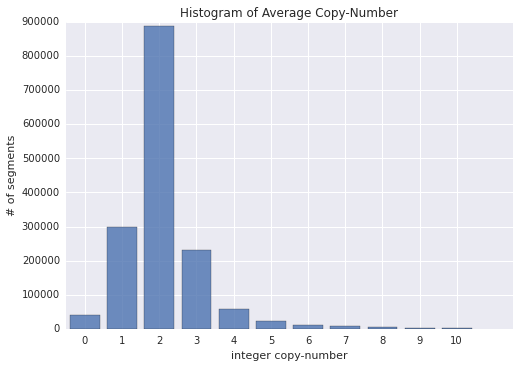

In [69]:
CNhist = bq.Query(getCNhist,t=cn_BQtable).results().to_dataframe()
bar_width=0.80
plt.bar(CNhist['lin_bin']+0.1,CNhist['n'],bar_width,alpha=0.8);
plt.xticks(CNhist['lin_bin']+0.5,CNhist['lin_bin']);
plt.title('Histogram of Average Copy-Number');
plt.ylabel('# of segments');
plt.xlabel('integer copy-number');

The histogram illustrates that the vast majority of the CN segments have a copy-number value near 2, as expected, with significant tails on either side representing deletions (left) and amplifications (right).

Let's take a look at the distribution of segment lengths now.  First we'll use 1Kb bins and look at segments with lengths up to 1 Mb.  

In [70]:
%%sql --module getSLhist_1k

SELECT
  bin,
  COUNT(*) AS n
FROM (
  SELECT
    (END-Start+1) AS segLength,
    INTEGER((END-Start+1)/1000) AS bin
  FROM
    $t
  WHERE
    (END-Start+1)<1000000 AND SampleTypeLetterCode="TP" )
GROUP BY
  bin
ORDER BY
  bin ASC

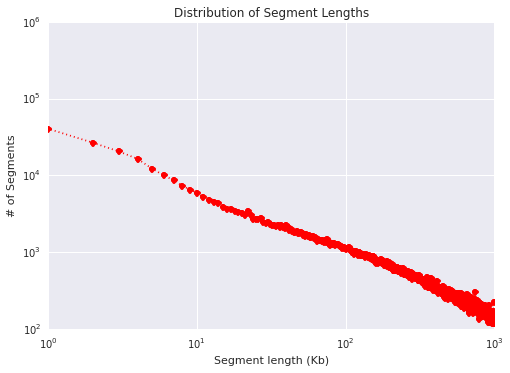

In [71]:
SLhist_1k = bq.Query(getSLhist_1k,t=cn_BQtable).results().to_dataframe()
plt.plot(SLhist_1k['bin'],SLhist_1k['n'],'ro:');
plt.xscale('log');
plt.yscale('log');
plt.xlabel('Segment length (Kb)');
plt.ylabel('# of Segments');
plt.title('Distribution of Segment Lengths');

As expected, shorter segment lengths dominate, and between 1Kb and 1Mb it appears that segment lengths follow a power-law distribution.

Let's have a closer look at the shorter segments, under 1Kb in length:

In [72]:
%%sql --module getSLhist

SELECT
  bin,
  COUNT(*) AS n
FROM (
  SELECT
    (END-Start+1) AS segLength,
    INTEGER((END-Start+1)/1) AS bin
  FROM
    $t
  WHERE
    (END-Start+1)<1000 AND SampleTypeLetterCode="TP" )
GROUP BY
  bin
ORDER BY
  bin ASC

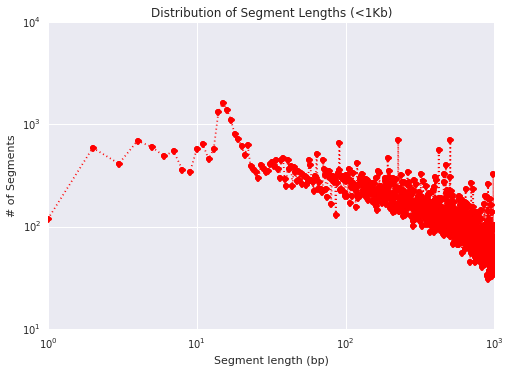

In [73]:
SLhist = bq.Query(getSLhist,t=cn_BQtable).results().to_dataframe()
plt.plot(SLhist['bin'],SLhist['n'],'ro:');
plt.xscale('log');
plt.yscale('log');
plt.xlabel('Segment length (bp)');
plt.ylabel('# of Segments');
plt.title('Distribution of Segment Lengths (<1Kb)');

At this finer scale, we see that the most comment segment length is ~15bp.

Let's go back and take another look at the medium-length CN segments and see what happens when we separate out the amplifications and deletions.  We'll use queries similar to the ``getSLhist_1k`` query above, but add another ``WHERE`` clause to look at amplifications and deletions respectively.

In [74]:
%%sql --module getSLhist_1k_del

SELECT
  bin,
  COUNT(*) AS n
FROM (
  SELECT
    (END-Start+1) AS segLength,
    INTEGER((END-Start+1)/1000) AS bin
  FROM
    $t
  WHERE
    (END-Start+1)<1000000 AND SampleTypeLetterCode="TP" AND Segment_Mean<-0.7 )
GROUP BY
  bin
ORDER BY
  bin ASC

In [75]:
%%sql --module getSLhist_1k_amp

SELECT
  bin,
  COUNT(*) AS n
FROM (
  SELECT
    (END-Start+1) AS segLength,
    INTEGER((END-Start+1)/1000) AS bin
  FROM
    $t
  WHERE
    (END-Start+1)<1000000 AND SampleTypeLetterCode="TP" AND Segment_Mean>0.7 )
GROUP BY
  bin
ORDER BY
  bin ASC

In [76]:
SLhistDel = bq.Query(getSLhist_1k_del,t=cn_BQtable).results().to_dataframe()
SLhistAmp = bq.Query(getSLhist_1k_amp,t=cn_BQtable).results().to_dataframe()

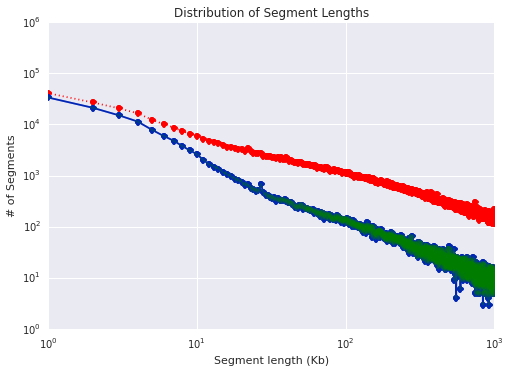

In [77]:
plt.plot(SLhist_1k['bin'],SLhist_1k['n'],'ro:');
plt.plot(SLhistDel['bin'],SLhistDel['n'],'bo-')
plt.plot(SLhistAmp['bin'],SLhistDel['n'],'go-',alpha=0.3)
plt.xscale('log');
plt.yscale('log');
plt.xlabel('Segment length (Kb)');
plt.ylabel('# of Segments');
plt.title('Distribution of Segment Lengths');

The amplification and deletion distributions are nearly identical and still seem to roughly follow a power-law distribution.

Before we leave this dataset, let's look at how we might analyze the copy-number as it relates to a particular gene of interest.  This next parameterized query looks for all copy-number segments overlapping a specific genomic region and computes some statistics after grouping by sample.

In [78]:
%%sql --module getGeneCN

SELECT
  SampleBarcode, 
  AVG(Segment_Mean) AS avgCN,
  MIN(Segment_Mean) AS minCN,
  MAX(Segment_Mean) AS maxCN,
FROM
  $t
WHERE
  ( SampleTypeLetterCode=$sampleType
    AND Num_Probes > 10
    AND Chromosome=$geneChr
    AND ( (Start<$geneStart AND End>$geneStop)
       OR (Start<$geneStop  AND End>$geneStop)
       OR (Start>$geneStart AND End<$geneStop) ) )
GROUP BY
  SampleBarcode

Now we'll use this query to get copy-number statistics for three widely-studied genes: EGFR, MYC and TP53.

In [79]:
# EGFR gene coordinates  
geneChr = "7"
geneStart = 55086725
geneStop = 55275031
egfrCN = bq.Query(getGeneCN,t=cn_BQtable,sampleType="TP",geneChr=geneChr,geneStart=geneStart,geneStop=geneStop).results().to_dataframe()

# MYC gene coordinates
geneChr = "8"
geneStart = 128748315
geneStop = 128753680
mycCN = bq.Query(getGeneCN,t=cn_BQtable,sampleType="TP",geneChr=geneChr,geneStart=geneStart,geneStop=geneStop).results().to_dataframe()

# TP53 gene coordinates
geneChr = "17"
geneStart = 7571720
geneStop = 7590868
tp53CN = bq.Query(getGeneCN,t=cn_BQtable,sampleType="TP",geneChr=geneChr,geneStart=geneStart,geneStop=geneStop).results().to_dataframe()

And now we'll take a look at histograms of the average copy-number for these three genes.  TP53 (in green) shows a significant number of partial deletions (CN<0), while MYC (in blue) shows some partial amplifications -- more frequently than EGFR, while EGFR (pale red) shows a few extreme amplifications (log2(CN/2) > 2). The final figure shows the same histograms on a semi-log plot to bring up the rarer events.

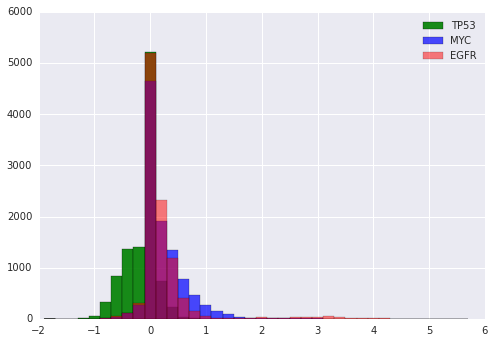

In [80]:
binWidth = 0.2
binVals = np.arange(-2+(binWidth/2.), 6-(binWidth/2.), binWidth)
plt.hist(tp53CN['avgCN'],bins=binVals,normed=False,color='green',alpha=0.9,label='TP53');
plt.hist(mycCN ['avgCN'],bins=binVals,normed=False,color='blue',alpha=0.7,label='MYC');
plt.hist(egfrCN['avgCN'],bins=binVals,normed=False,color='red',alpha=0.5,label='EGFR');
plt.legend(loc='upper right');

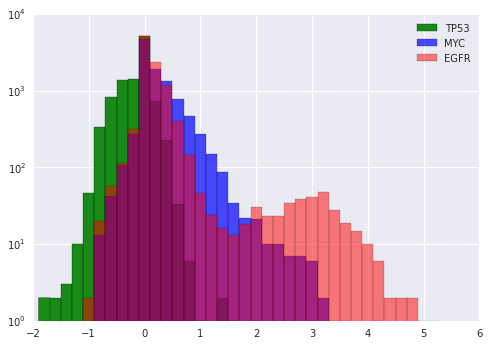

In [81]:
plt.hist(tp53CN['avgCN'],bins=binVals,normed=False,color='green',alpha=0.9,label='TP53');
plt.hist(mycCN ['avgCN'],bins=binVals,normed=False,color='blue',alpha=0.7,label='MYC');
plt.hist(egfrCN['avgCN'],bins=binVals,normed=False,color='red',alpha=0.5,label='EGFR');
plt.yscale('log');
plt.legend(loc='upper right');